In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm, chi2
from glob import glob
import os

In [13]:
#パスの指定
folder_path = 'test' #Excelの入ったフォルダ
output_path = 'imgs' #散布図を出力するフォルダ（自由に変更可能）
output_fname = 'output.xlsx' #結果をまとめた出力ファイル名（自由に変更可能）

#出力フォルダの作成
os.makedirs(output_path, exist_ok=True)

#Excelファイルのパスの取得、ファイル数を出力
files  = glob(os.path.join(folder_path, '**/*.xlsx'), recursive=True)
len(files)

8

In [14]:
#p%のデータが含まれる楕円を求める関数
def calc_ellipse(data, p, sigma):
    #楕円の中心 = データの中心
    means = np.mean(data, axis=0)
    
    #分散共分散行列の固有値と固有ベクトルを計算
    cov = np.cov(data[:,0], data[:,1])
    lambdas, vecs = np.linalg.eigh(cov)
    
    #固有値の大きい順に並び変え、第一主成分軸と第二主成分軸を求める
    order = lambdas.argsort()[::-1] 
    lambdas, vecs = lambdas[order], vecs[:,order]
    #確率pのときのマハラノビス距離を計算
    c = np.sqrt(chi2.ppf(p, 2))
    #各主成分軸上で上のマハラノビス距離になる点の座標を求め2倍する ＝ 楕円の直径
    w, h = 2 * c * np.sqrt(lambdas)
    #楕円の角度を計算
    #旧
    #theta = np.degrees(np.arctan(
    #        ((lambdas[0] - lambdas[1])/cov[0,1])))
    #新
    theta = np.rad2deg(np.arctan(vecs[1, 0]/vecs[0, 0]))
    
    #楕円を描画するための情報
    el = Ellipse(xy=means,
                 width=w, height=h,
                 angle=theta, 
                 color="black", 
                 fill=False,
                 label=f'{sigma}σ',
                 linestyle=['-', '--', ':'][sigma-1])
    
    #楕円の長軸上と短軸上の点の座標を計算
    a1 = np.linalg.norm(vecs[:, 0].flatten(), ord=2)
    w1 = means + (w/(2.0 * a1)) * vecs[:, 0].flatten()
    w2 = means - (w/(2.0 * a1)) * vecs[:, 0].flatten()
    
    a2 = np.linalg.norm(vecs[:, 1].flatten(), ord=2)
    h1 = means + (h/(2.0 * a2)) * vecs[:, 1].flatten()
    h2 = means - (h/(2.0 * a2)) * vecs[:, 1].flatten()
    
    x_max = max(w1[0], w2[0], h1[0], h2[0])
    x_min = min(w1[0], w2[0], h1[0], h2[0])
    y_max = max(w1[1], w2[1], h1[1], h2[1])
    y_min = min(w1[1], w2[1], h1[1], h2[1])
    ranges = (x_min, x_max, y_min, y_max)

    return el, np.pi*w*h/4, w/2, h/2, ranges  #面積は半径1×半径2×π

#1σ~3σの当確率楕円の面積を求め、描画する関数
def confidence_ellipse(data, file):
    #散布図を作成
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(data[:,0], data[:,1])
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    
    #1σ~3σの等確率楕円を描画し面積を求める
    areas = [] #3つの面積を格納するリスト
    widths = [] #3つの半径（長い方）を格納するリスト
    heights = [] #3つの半径（短い方）格納するリスト 
    #各σでの処理
    for sigma in range(1, 4):
        p = 1 - (1 - norm.cdf(sigma))*2 #1σ, 2σ, 3σ内に含まれる確率
        el, area, w, h,  ranges = calc_ellipse(data, p, sigma) #データと確率から楕円と面積、距離を計算
        #値を格納
        areas.append(area)
        widths.append(w)
        heights.append(h)
        #ax.add_artist(el)#楕円を描画
        ax.add_patch(el)
        
    #3σの楕円の頂点からグラフの範囲を計算
    ma = max(ranges[1], ranges[3])
    mi = min(ranges[0], ranges[2])
    ax.set_xlim(mi-50, ma+50) 
    ax.set_ylim(mi-50, ma+50)
    
    #グラフの保存
    plt.legend()
    img_name = file_name = os.path.splitext(os.path.basename(file))[0]+'.png'
    plt.savefig(os.path.join(output_path, img_name))
    plt.show()
    
    return areas, widths, heights 

次のファイルでエラーが発生しました。 test\error.xlsx


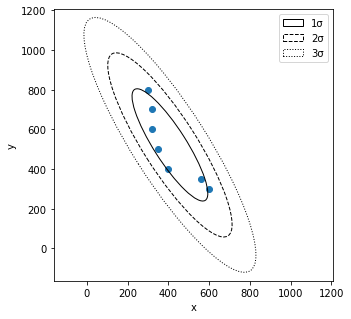

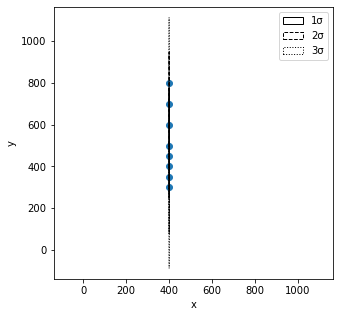

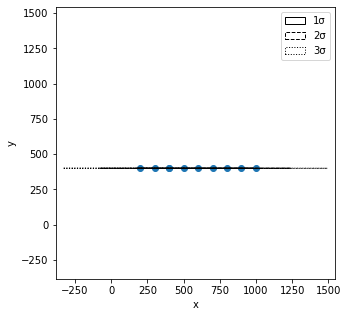

C:\Users\gensh\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\gensh\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\gensh\AppData\Local\Temp/ipykernel_34976/695780369.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.rad2deg(np.arctan(vecs[1, 0]/vecs[0, 0]))


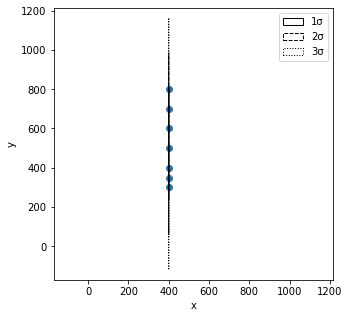

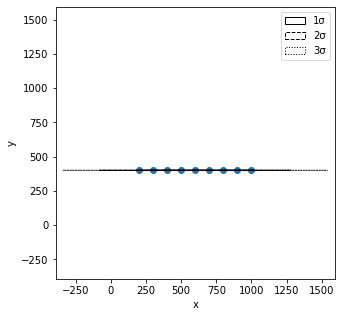

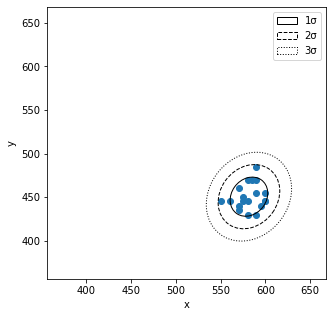

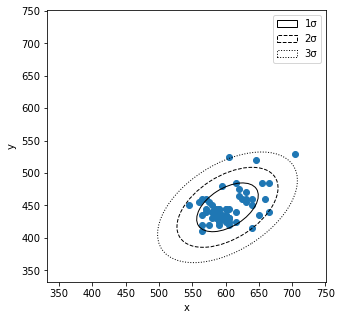

,ファイル名,確率楕円の面積(1σ),確率楕円の面積(2σ),確率楕円の面積(3σ),確率楕円の長半径(1σ),確率楕円の長半径(2σ),確率楕円の長半径(3σ),確率楕円の短半径(1σ),確率楕円の短半径(2σ),確率楕円の短半径(3σ),相関係数
0,test1.xlsx,83031.397953,223517.564418,427830.552282,329.044255,539.869715,746.911308,80.322675,131.787075,182.327798,-0.864989
1,test2.xlsx,440.910094,1186.914262,2271.849130,264.768464,434.411095,601.009004,0.530071,0.869698,1.203230,-0.144518
2,test3.xlsx,588.882480,1585.250650,3034.296938,402.781501,660.851940,914.290565,0.465382,0.763561,1.056389,-0.237915
3,test4.xlsx,0.000000,0.000000,0.000000,282.980404,464.291802,642.349048,0.000000,0.000000,0.000000,NaN
4,test5.xlsx,0.000000,0.000000,0.000000,414.947189,680.812436,941.905970,0.000000,0.000000,0.000000,NaN
5,test6.xlsx,1454.938157,3916.641671,7496.766411,23.695542,38.877766,53.787501,19.544655,32.067320,44.365230,0.178624
6,test7.xlsx,4771.056113,12843.513038,24583.514457,51.943723,85.225140,117.909227,29.236917,47.969615,66.366101,0.486958


In [15]:
#各ファイルの結果を格納する配列
result = []

#各ファイルごとの処理
for file in files:
    #ファイルを読み込み, 1列目をx, 2列目をyに代入
    data = pd.read_excel(file).values
    x = data[:, 0]
    y = data[:, 1]
    
    #相関係数の計算
    try:
        corr = np.corrcoef(x, y)[0, 1] #相関係数行列の0行1列の値。1行0列目でも同じ

        #1~3σの確率楕円の面積とマハラノビス距離
        area, widths, heights = confidence_ellipse(data, file)
    
        #ファイル名の処理
        file_name = os.path.basename(file) #出力結果のファイル名に拡張子をつける場合
        #file_name = os.path.splitext(os.path.basename(file))[0] #拡張子がいらない場合   
    
        #１つのファイルの結果の格納
        result.append([file_name] + area + widths + heights + [corr])
        
    except:
        print('次のファイルでエラーが発生しました。', file)

#結果をpandasのDataFrameに変換
result_df = pd.DataFrame(result, columns = ['ファイル名', '確率楕円の面積(1σ)', '確率楕円の面積(2σ)', '確率楕円の面積(3σ)', 
                                            '確率楕円の長半径(1σ)', '確率楕円の長半径(2σ)', '確率楕円の長半径(3σ)', 
                                            '確率楕円の短半径(1σ)', '確率楕円の短半径(2σ)', '確率楕円の短半径(3σ)', 
                                            '相関係数'])

result_df

In [16]:
#Excelにして保存
result_df.to_excel(output_fname, index = False)